# Code for the final report in 02456 Deep Learning 

**Authors:** *Mads Emil Dahlgaard (S164206), Morten Wehlast Jørgensen (S147056), and Niels Asp Fuglsang (S164181)*

This notebook explains the code and recreates the main results from the report *An analysis of levers in deep reinforcement learning and how they affect learning speed and generalization*. The full code base can be found at https://github.com/NielsFuglsang/02456-Deep-Learning.

---

## Introduction

Deep reinforcement learning is notourisly known for results that are difficult to reproduce. Even very small changes to hyperparameters can lead to completely different results. Therefore, in this project we set out to investigate how to best increase one's chances of improving model performance. We identified the following 3 areas.
- Data set size
- Input transformation
- Choice of policy optimization algorithm
We believe that these three areas are important for any reinforcement learning practioner and particularly for newcomers to the field.

In order to investigate this we use the Starpilot environment from ProcGen Benchmark. The procedurally generated environment allows for virtually unlimited training data and is a perfect starting point for investigating the importance of data set size. In order to explore input transformation we chose to focus on to different convolutional neural networks; the simple Nature CNN and the more advanced IMPALA CNN. Lastly, we compare the state-of-the-art policy optimization algorithms PPO and TRPO. To sum up, we conclude the following three points.
- Data set size: larger volumes of varied data generally improves generalization
- Encoders: IMPALA CNN outperforms Nature CNN even on smaller tasks
- Policy optimization: PPO is both simpler and better performing than TRPO

## Technical stack

The Python version is 3.7.7 64 bit. All experiments are run on DTU HPC GPU nodes. Specifically, the experiments are run on the `gpuv100` queue consisting of 10 nodes with 2 Nvidia Tesla V100 Tensor Core GPUs - 6 of the nodes have 16GB ram and 4 of the nodes 32GB. The following list contains the most significant modules used. For a full list see `requirements.txt` in the Github repository.
- CUDA 9.2
- CuDNN 7.4.2.24
- Jupyter Lab 2.2.9
- Matplotlib 3.3.3
- Numpy 1.19.4
- OpenAI Gym 0.17.3
- Procgen 0.10.4
- PyTorch 1.7.0

## Code structure

We tried to make our code as modular as possible. The overall code structure looks like this

```
├── src
│   └── init.py
│   └── encoder.py         # Classes for each encoder structure.
│   └── experiment.py      # Class for training and evaluating a policy.
│   └── policy.py          # PPO and TRPO classes. 
│   └── utils.py           # Functions for keeping track of environments and data.
├── params
│   └── ...                # JSON files specifying experiment hyperparameters.
├── .gitignore
├── README.md
├── job.sh                 # Jobscript for running on HPC.
├── requirements.txt       # Python modules.
├── run_experiment.py      # Read parameters from JSON file, train, and evaluate policy.
├── sender.sh              # Helper function to submit jobs on HPC.
```

The folder `src` contains the main code for this project and is structured as a Python package. The file `encoder.py` implements the two Convolutional Neural Networks used in this project; Impala CNN and Nature CNN. The file `policy.py` contains classes for `PPO` and `TRPO` respectively with two main class methods; `act` for using the policy and sampling an action, and `loss` for returning the policy loss given some observation.

The file `experiment.py` contains code for training and evaluating a policy in an environment. The `Experiment` class from `experiment.py` is independent from the choice of encoder and policy. This means that the same code can be used to train both a TRPO and a PPO policy. Therefore, we just need to specify the encoder, the policy, and the hyperparameters when creating the `Experiment` class. As an example, in order to train a PPO network with the IMPALA CNN as encoder the following code is sufficient.

```python
exp = Experiment(params)
encoder = Impala(in_channels, feature_dim)
policy = PPO(encoder, feature_dim, num_actions)
policy, log = exp.train(env, policy, optimizer, storage)
```

Notice the variables `params`, `in_channels`, `feature_dim`, and so on. They are all hyperparameters needed to train and evaluate the policy. The combination of policy optimization algorithm, encoder, and hyperparameters is essentially what defines an experiment. We came up with a way to specify all the parameters needed to run an experiment, which enabled us to easily conduct multiple different experiments without changing the code. All the experiments are specified as JSON files in the folder `params`. An experiment could look like this.

```JSON
{
    "total_steps" : 2e6,
    "num_envs": 32,
    "num_levels": 10,
    "num_steps": 256,
    "num_epochs": 3,
    "batch_size": 512,
    "eps": 0.2,
    "grad_eps": 0.5,
    "value_coef": 0.5,
    "entropy_coef": 0.01,
    "feature_dim": 128,
    "policy": "ppo",
    "encoder": "nature",
    "beta": 0,
    "lr": 5e-4
}
```

The Python file `run_experiment.py` then takes as argument the filename of a JSON file with experiment parameters and runs the entire pipeline, i.e., train, evaluate, and save the results. If the above parameters are stored in `params/experiment1.json`, then the experiment can be executed by the following command.
```sh
>> python run_experiment.py experiment1
```

### Running the code on DTU HPC

We needed to specify the above as a jobscript in order to run the experiments on the DTU HPC cluster queue system. The jobscript is shown below.

```sh
#!/bin/sh
#BSUB -q gpuv100
#BSUB -gpu "num=1"
#BSUB -J name
#BSUB -n 1
#BSUB -W 10:00
#BSUB -R "rusage[mem=32GB]"
#BSUB -o logs/name.out
#BSUB -e logs/name.err

cd /zhome/ff/2/118359/projects/02456-Deep-Learning
source .venv/bin/activate

echo "Running script..."
python run_experiment.py name
```

Now in order to simplify this even further we created a small shell script that exchanges `name` in the above with an input argument and submits it to the queue using `bsub`. This script is called `sender.sh`. Therefore, one can simply conduct an experiment by creating a parameters JSON file and submitting the experiment like this
```sh
source sender.sh name_of_experiment
```

This way we could easily specify and run the different experiments.

## Training loop

In the training loop we both generate the training data and train on that data. This is possible since we are dealing with a procedurally generated environment. Therefore, the training loop goes like this.
- Generate `num_steps` of training data.
- Go over that training data for `num_epochs`.
     - For each epoch calculate the loss, perform backward propagation, and update the policy.
- Generate new data and evaluate the test reward.

The above loop is run as long as the acummulated number of steps is less than `num_steps`. Notice that this is different from most real life machine learning since we are able to simply generate new data. Furthermore, the above is run simultaneously in parallel for 32 environments to speed up the process.

In order to compare training and test performance it is important that these two metrics are evaluated in the same way. We therefore use mean episodic reward. The mean episodic reward is calculated by running all 32 environments for one episode and taking the average reward over the 32 environemnts. One episode is defined from when the agent starts playing until it fails. Here is a code snippet showing how this is implemented.
```python
workers_finished = np.zeros((self.num_envs), dtype=bool)
while not np.all(workers_finished):

    # Use policy.
    action, _, _, _ = policy.act(obs)

    # Take step in environment.
    obs, reward, done, _ = env.step(action)
    for i in range(self.num_envs):
        if done[i]:
            workers_finished[i] = True
        if workers_finished[i]:
            reward[i] = 0

    total_reward.append(torch.Tensor(reward))
   
# Calculate average reward
mean_reward = torch.stack(total_reward).sum(0).mean(0)
```

This also means that the same code can be used to evaluate both training and test mean episodic reward simply by specifying what levels the agent should be evaluated on.

## Saving the results and logging

For each experiment we save a log of the progress. This log looks like this
```python
log = {
    'step': steps,
    'train_mean_reward': train_mean_reward,
    'train_min_reward': train_min_reward,
    'train_max_reward': train_max_reward,
    'test_mean_reward': test_mean_reward,
    'test_min_reward': test_min_reward,
    'test_max_reward': test_max_reward,
    'pi_loss': pi_loss,
    'value_loss': value_loss,
    'entropy_loss': entropy_loss,
    'test_var': test_vars,
    'train_var': train_vars
}
```

where each variable is a list of size `total_steps/num_steps`, i.e., the number of training loops. We use the function `torch.save` to save the logging files in the pickle serialization format. The results are saved to the `results` folder.

---

## Recreating the main results

It is unatainable to show all of the main results here since the experiments were run on the DTU HPC cluster with a compute time of multiple hours. Therefore, we will here show a much smaller experiment that showcases the procedure.

First we import the relevant modules. We need `torch` and then some custom modules contained in the `src` folder. We important the `Experiment` class and the classes for the encoders and the policies.

In [1]:
import torch
from src.utils import make_env, Storage
from src import Experiment, Nature, Impala, PPO, TRPO

Now we need to specify the experiment. Here a relatively simple experiment is specified. We only run the experiment for 5e5 timesteps and with 10 training levels.

In [2]:
params = {
    "total_steps" : 5e5,
    "num_envs": 32,
    "num_levels": 10,
    "num_steps": 256,
    "num_epochs": 3,
    "batch_size": 512,
    "eps": 0.2,
    "grad_eps": 0.5,
    "value_coef": 0.5,
    "entropy_coef": 0.01,
    "feature_dim": 32,
    "policy": "ppo",
    "encoder": "impala",
    "beta": 0,
    "lr": 5e-4
}

The above dictionary is the only thing that needs to be changed in order to conduct a different experiment - this makes it easy to try out different hypotheses. 

Next we create the Procgen Starpilot training environment. We specify that we want to train on the levels from 0 to `num_levels` which in this case is 10.

In [3]:
env = make_env(params["num_envs"], env_name='starpilot', start_level=0, num_levels=params["num_levels"])

We can then define the encoder. This is done in the following way.

In [4]:
feature_dim = params['feature_dim']
in_channels = 3 # RGB
encoders = {
    "nature": Nature(in_channels, feature_dim),
    "impala": Impala(in_channels, feature_dim)
    }
encoder = encoders[params['encoder']]

The policy is defined in a similar way. Furthermore, the policy is moved to the GPU by the command `policy.cuda()`. The policy is printed to for inspection of the encoder, policy, and value network.

In [5]:
num_actions = env.action_space.n
policies = {
    "ppo": PPO(encoder, feature_dim, num_actions),
    "trpo": TRPO(encoder, feature_dim, num_actions, beta=params['beta'])
}
policy = policies[params['policy']]
policy.cuda()
print(policy)

PPO(
  (encoder): Impala(
    (layers): Sequential(
      (0): ImpalaBlock(
        (block): Sequential(
          (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
          (2): ResidualBlock(
            (layers): Sequential(
              (0): ReLU()
              (1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
              (2): ReLU()
              (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            )
          )
          (3): ResidualBlock(
            (layers): Sequential(
              (0): ReLU()
              (1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
              (2): ReLU()
              (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            )
          )
        )
      )
      (1): ImpalaBlock(
        (block): Sequential(
          (0): Conv2d(16, 32, 

Throughout all experiments we have used the Adam optimizer. In our final experiments we have kept the learning rate consistent to avoid too many variying factors that could influence the results. Similarly, we have not utilized weight decay. The optimizer is defined as follows.

In [6]:
optimizer = torch.optim.Adam(policy.parameters(), lr=params['lr'])

We then define a temporary storage for collecting and keeping track of transitions during each training iteration.

In [7]:
storage = Storage(
    obs_shape=env.observation_space.shape,
    num_steps=params["num_steps"],
    num_envs=params["num_envs"],
    act_shape=num_actions
)

The experiment class is then initialized. This is were the remaining parameters in the `param` dictionary become important. Variables such as `total_steps`, `num_steps`, and `batch_size` are used in the training loop.

In [8]:
exp = Experiment(params)

Finally we can train the policy and collect the log. Notice the `verbose=True` argument enables intermediate printing to the console. This would normally be set to false except when debugging or explicitly showing results.

In [9]:
policy, log = exp.train(env, policy, optimizer, storage, verbose=True)

Step: 8192	Mean train reward: 3.5719480514526367
		Mean test reward: 3.950568675994873
Step: 16384	Mean train reward: 2.9858241081237793
		Mean test reward: 3.968907117843628
Step: 24576	Mean train reward: 3.2133965492248535
		Mean test reward: 2.963378667831421
Step: 32768	Mean train reward: 3.6365129947662354
		Mean test reward: 3.363976001739502
Step: 40960	Mean train reward: 3.9814295768737793
		Mean test reward: 2.472883701324463
Step: 49152	Mean train reward: 3.688166618347168
		Mean test reward: 3.7151870727539062
Step: 57344	Mean train reward: 4.142335891723633
		Mean test reward: 4.50001335144043
Step: 65536	Mean train reward: 4.587725639343262
		Mean test reward: 4.2706685066223145
Step: 73728	Mean train reward: 4.629404544830322
		Mean test reward: 4.424867630004883
Step: 81920	Mean train reward: 5.042035102844238
		Mean test reward: 5.320296764373779
Step: 90112	Mean train reward: 5.475069999694824
		Mean test reward: 5.218132972717285
Step: 98304	Mean train reward: 6.65307

We can then save the results. We both save the policy and the log.

In [10]:
torch.save(policy.state_dict, 'overview-policy.pt') # Save policy.
torch.save(log, 'overview.pt') # Save logging.

## Visualizing the results

The folder `results` contains python scripts for plotting the figures in our poster and report. Below we will plot a figure for the small experiment we just carried out.

In [11]:
import matplotlib.pyplot as plt
from matplotlib import rc

Read the log of the experiment we just carried out.

In [12]:
exp = torch.load('overview.pt', map_location=torch.device('cpu'))

Specify the plotting and text style.

In [13]:
plt.style.use('seaborn-poster')
plt.rc('grid', linestyle="--", color='grey', alpha=0.2)
rc('font', **{'family': 'serif'})
rc('text', usetex=True)

Create figure, specify axis options, and plot test and train mean episodic reward.

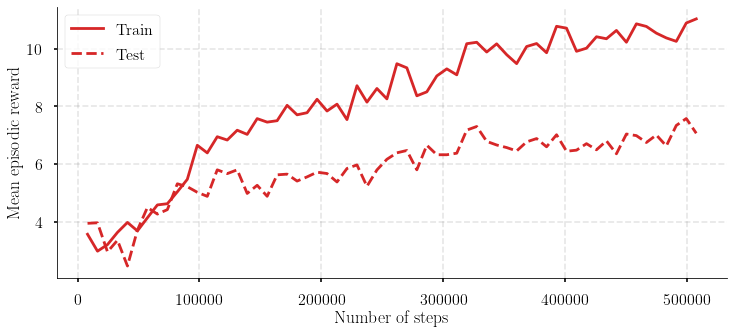

In [14]:
fig, ax = plt.subplots(figsize=(12,5))
ax.grid(True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.plot(exp['step'], exp['train_mean_reward'], 'C3')
ax.plot(exp['step'], exp['test_mean_reward'], 'C3--')
ax.set_xlabel('Number of steps')
ax.set_ylabel('Mean episodic reward')
ax.legend(['Train', 'Test'])
plt.show()

We see that training error is larger than the test error. This is to be expected. However, the plot also indicates that the policy is actually learning something. It is, however, important to note that the model is only trained for 5e5 steps.

## Wrapping up

In this notebook we have described the overall structure of the code and the experiments. All of the experiments carried out can be found in the folder `params` - we carried out more than 51 experiments with compute times ranging from 1.5 to 8 hours. The results and the scripts for visualizing can be found in the folder `results` in the pickle serialization format. The code shown here should work as an overview of the code base. For a better understanding of how we implement PPO, TRPO, and IMPALA CNN, see the report and the full code base on Github.

The code can be found here: https://github.com/NielsFuglsang/02456-Deep-Learning.

Videos of the agents playing can be seen here: https://bit.ly/39OGphQ